In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from delta import *
import logging

In [2]:
# Paths
GOLDEN_TABLE_PATH = '/opt/data_lake/golden/house_prices'
PREDICTIONS_TABLE_PATH = '/opt/data_lake/golden/house_prices_predictions'
MODEL_ARTIFACTS_PATH = '/opt/model_artifacts/model'

In [3]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [4]:
# Create Spark Session
builder = (
    SparkSession
    .builder
    .appName("real-estate-etl")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

:: loading settings :: url = jar:file:/usr/local/spark-3.1.2-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/airflow/.ivy2/cache
The jars for the packages stored in: /home/airflow/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-21459ba4-540a-43b8-93aa-86f81b6d6f68;1.0
	confs: [default]


	found io.delta#delta-core_2.12;1.0.0 in central
	found org.antlr#antlr4;4.7 in central


	found org.antlr#antlr4-runtime;4.7 in central
	found org.antlr#antlr-runtime;3.5.2 in central
	found org.antlr#ST4;4.0.8 in central


	found org.abego.treelayout#org.abego.treelayout.core;1.0.3 in central
	found org.glassfish#javax.json;1.0.4 in central
	found com.ibm.icu#icu4j;58.2 in central


:: resolution report :: resolve 1056ms :: artifacts dl 39ms
	:: modules in use:
	com.ibm.icu#icu4j;58.2 from central in [default]
	io.delta#delta-core_2.12;1.0.0 from central in [default]
	org.abego.treelayout#org.abego.treelayout.core;1.0.3 from central in [default]
	org.antlr#ST4;4.0.8 from central in [default]
	org.antlr#antlr-runtime;3.5.2 from central in [default]
	org.antlr#antlr4;4.7 from central in [default]
	org.antlr#antlr4-runtime;4.7 from central in [default]
	org.glassfish#javax.json;1.0.4 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   8   |   0   |   0   |   0   ||   8   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-

22/07/09 22:49:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
# Load data
data = (
    spark
    .read
    .format('delta')
    .load(GOLDEN_TABLE_PATH)
    .withColumn('label', F.col('normalized_price'))
)

logger.info(f"Using {data.count()} datapoints to fit the model.")

2022-07-09 22:50:13,459 [INFO] Using 3546 datapoints to fit the model.


In [6]:
# Split train and test datasets
train_data, test_data = data.randomSplit([0.8, 0.2])

In [7]:
free_columns = ['attributes_inside_attic', 'attributes_inside_cellar', 'attributes_technology_dishwasher',
                'attributes_technology_cable_tv', 'attributes_outside_balcony', 'attributes_outside_playground',
                'attributes_outside_parking', 'attributes_outside_garage']

In [8]:
# One Hot Encoding Categorical Variables
categorical_columns = ['city']

cat_indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]

cat_encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in cat_indexers
]

cat_assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in cat_encoders], outputCol="cat_features")

In [9]:
# Standard Scaler Numerical Variables
numerical_columns = ['number_of_rooms', 'surface_property', 'surface_living']

num_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="num_features")
output = num_assembler.transform(train_data)

num_scaler = StandardScaler(inputCol="num_features", outputCol="scaledFeatures")


In [10]:
# Fit Linear Regression
features = VectorAssembler(inputCols= free_columns + ['cat_features', 'num_features'], 
                           outputCol="features")

lr = LinearRegression()

# Fit the whole pipeline
pipeline = Pipeline(stages = cat_indexers + cat_encoders + [cat_assembler] + [num_assembler] + [num_scaler] + [features] + [lr])
model=pipeline.fit(train_data)
train_data_transformed = model.transform(train_data)

22/07/09 22:50:21 WARN Instrumentation: [ae0f6a51] regParam is zero, which might cause numerical instability and overfitting.


22/07/09 22:50:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/07/09 22:50:21 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


22/07/09 22:50:21 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/07/09 22:50:21 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [11]:
# Calculate model metrics on training data
training_summary = model.stages[-1].summary
logger.info(f"RMSE: {training_summary.rootMeanSquaredError}")
logger.info(f"R Squared (R2) on test data: {training_summary.r2}")

2022-07-09 22:50:24,756 [INFO] RMSE: 1475771.7157919668


2022-07-09 22:50:24,769 [INFO] R Squared (R2) on test data: 0.3718749172054404


In [12]:
# Calculate model metrics on test data
test_data_transformed = model.transform(test_data)

lr_evaluator = RegressionEvaluator(predictionCol="prediction",
                                   labelCol="label",metricName="r2")

logger.info(f"R Squared (R2) on test data = {lr_evaluator.evaluate(test_data_transformed)}")

2022-07-09 22:50:26,782 [INFO] R Squared (R2) on test data = 0.2016755344732224


2022-07-09 22:50:30,609 [WARNING] Matplotlib created a temporary config/cache directory at /tmp/matplotlib-wrvectn8 because the default path (/home/airflow/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


2022-07-09 22:50:31,065 [INFO] generated new fontManager


<AxesSubplot:ylabel='Frequency'>

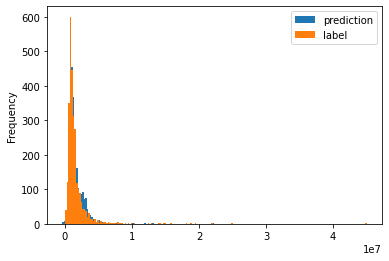

In [13]:
train_data_transformed.toPandas()[['prediction', 'label']].plot.hist(bins=200)

<AxesSubplot:ylabel='Frequency'>

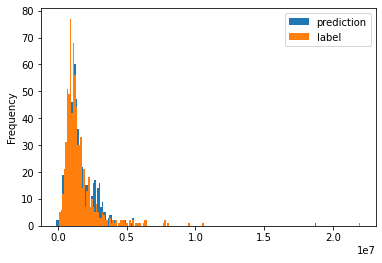

In [14]:
test_data_transformed.toPandas()[['prediction', 'label']].plot.hist(bins=200)

In [15]:
# Store the predictions as a delta table
predicted_data = model.transform(data)

(
    predicted_data
    .write
    .format('delta')
    .mode('overwrite')
    .option('mergeSchema', 'true')
    .save(PREDICTIONS_TABLE_PATH)
)

In [16]:
# # Vacuum table
# delta_table = DeltaTable.forPath(spark, PREDICTIONS_TABLE_PATH)
# delta_table.vacuum()

In [17]:
# Check model coefficients
logger.info(f"Coefficients: {str(model.stages[-1].coefficients)}")
logger.info(f"Intercept: {str(model.stages[-1].intercept)}")

2022-07-09 22:50:50,737 [INFO] Coefficients: [-318956.68121090275,52413.31757561251,160204.82101045994,76305.4857467708,24524.880689026446,-176846.853424646,-194014.49186956912,247354.5933805163,-457320.0382093858,-403237.632910785,-66328.46363935678,1285510.2547850672,224467.54178709353,38.72980771337505,1332.702862549369]


2022-07-09 22:50:50,739 [INFO] Intercept: -211909.2811031914


In [18]:
# Save trained model
model.write().overwrite().save(MODEL_ARTIFACTS_PATH)